# **Initializations**

In [1]:
import pickle,gzip,math,os,time,shutil,torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [9]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

#set_seed(42)

## **Recreating the Case of Faulty Initializations**

Recall that in the previous NB, `10_activations`,  we were able to use Hooks to visualize the layerwise activations of a simple baseline CNN which uses a `MomentumLearner`. This proved to be a powerful technique to identify and diagnose any issues during the early stages of the training process.

We also established that while the baseline model had improved loss and accuracy metrics when compared to the standard `Learner`, it still began training incorrectly. This could be observed in the poor activation stats for its different layers. 

Let's proceed to recreate the faulty CNN to see how the issue can be fixed.

In [10]:
# Load Data and run inplace transformations
xl, yl = 'image', 'label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

# Batch size and transforms
bs = 1024
tds = dsd.with_transform(transformi)

In [11]:
# Load the data onto Dataloader and create batches
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

In [12]:
# Setup model
def get_model():
    return nn.Sequential(conv(1, 8), 
                         conv(8, 16),
                         conv(16, 32),
                         conv(32, 64),
                         conv(64, 10, act=False),
                         nn.Flatten()).to(def_device)

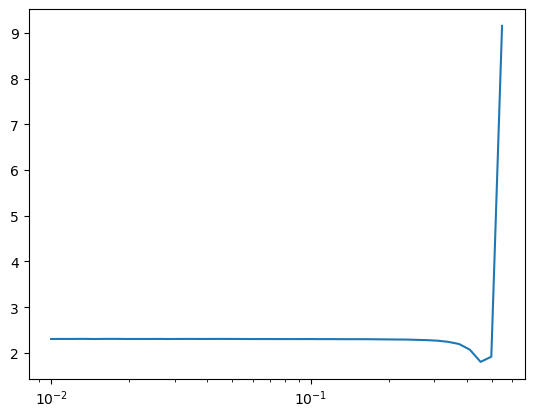

In [14]:
# Find a good learning rate using the LR Finder
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [15]:
# Setup metrics, activation stats, callbacks and learner
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.182,2.422,0,train
0.100,2.303,0,eval


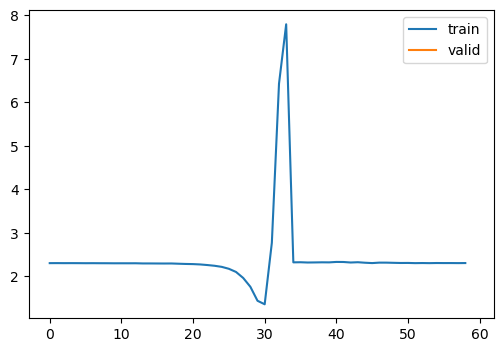

In [16]:
# Fit one epoch
learn.fit(1)

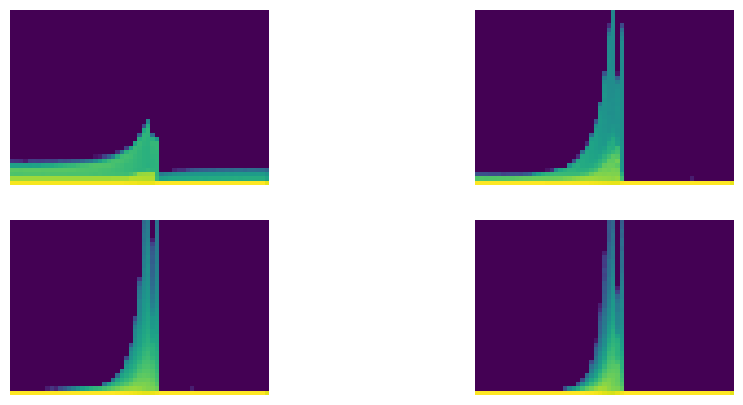

In [17]:
# Activation stats for the model's layers following one epoch of training
astats.color_dim();

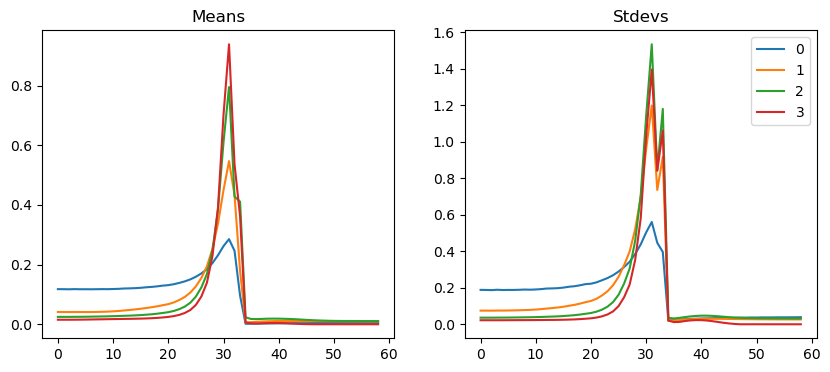

In [18]:
# Means and Standard Deviations of activations
astats.plot_stats();